# Human sleep data

- Available at <https://www.uni-goettingen.de/de/551628.html>
- used in `kneib2008bayesian` and `titman2020general`

In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import collections
import matplotlib.pyplot as plt
import numpy as np

from mixmarkov import (
    CTMC,
    FiniteMixCTMC,
    GamMixCTMC,
    MGamMixCTMC,
    summarize_sequences,
)
from mixmarkov.baselines import CTRNN, seqs_to_tensor
from mixmarkov.utils import draw_chain

## Loading the data

Fields:

- `id`: ID of the individual
- `st`: state. `1` is awake, `2` is non-REM sleep and `3` is REM sleep.
- `beg` and `end`: interval during which measurement is valid.
- `tas`, `tsa`, `tnr`, `trn`: indicator variable of transition at the end of the interval.
   Can be all zeros if no transition occurred.
   Semantics: awake <-> sleep, non-REM <-> REM.
- `cortisol`: cortisol level measured during interval.

In [2]:
data = collections.defaultdict(list)
with open("../data/sleep.dat") as f:
    next(f)  # First line is header.
    for line in f:
        idx, st, beg, end, tas, tsa, tnr, trn, cortisol = line.strip().split(" ")
        idx = int(idx)
        st = int(st)
        ival = (float(beg), float(end))
        trans = np.array(list(map(int, (tas, tsa, tnr, trn))))
        cortisol = float(cortisol)
        data[idx].append((st, ival, trans, cortisol))

In [3]:
seqs = list()

for idx, vals in data.items():
    seq = list()
    cur = None
    for st, (beg, end), _, _ in vals:
        if st != cur:
            seq.append((st-1, beg))
        cur = st
    seqs.append(seq)

# Shuffle the sequences.
rng = np.random.default_rng(seed=0)
idx = rng.permutation(len(seqs))
seqs = np.array(seqs, dtype=object)[idx]

# states: 3
# sequences: 70
# edges: 6


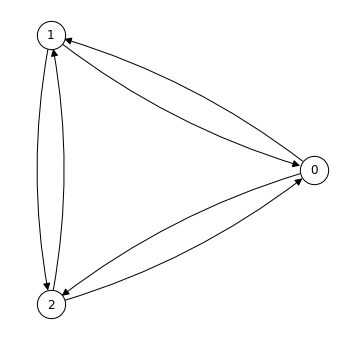

In [4]:
states = set()
for seq in seqs:
    for x, y in seq:
        states.add(x)
        
n = len(states)
        
ks, _ = summarize_sequences(seqs, n)
mask = np.sum(ks, axis=0).astype(bool)
np.fill_diagonal(mask, False)  # Remove self-transitions

print(f"# states: {n:,}")
print(f"# sequences: {len(seqs):,}")
print(f"# edges: {mask.sum():,}")

draw_chain(mask)

## Final evaluation

In [5]:
model1 = CTMC(mask)
model2 = MGamMixCTMC(mask)
model3 = GamMixCTMC(mask)

n_splits = 10
zs = np.linspace(0, len(seqs), num=(n_splits + 1), dtype=int)

res1 = np.zeros(n_splits)
res2 = np.zeros(n_splits)
res3 = np.zeros(n_splits)

for i, (z1, z2) in enumerate(zip(zs[:-1], zs[1:])):
    train = np.concatenate((seqs[:z1], seqs[z2:]))
    valid = seqs[z1:z2]
    ks_train, ts_train = summarize_sequences(train, n)
    ks_valid, ts_valid = summarize_sequences(valid, n)
    # CTMC
    model1.fit(ks_train, ts_train)
    res1[i] = model1.predictive_loglike(ks_valid, ts_valid) / len(ks_valid)
    # MGamMixCTMC
    model2.fit(ks_train, ts_train)
    res2[i] = model2.predictive_loglike(ks_valid, ts_valid) / len(ks_valid)
    # GamMixCTMC
    model3.fit(ks_train, ts_train)
    res3[i] = model3.predictive_loglike(ks_valid, ts_valid) / len(ks_valid)

Optimization terminated successfully.
         Current function value: 16001.622753
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
         Hessian evaluations: 15
Optimization terminated successfully.
         Current function value: 15893.461631
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
         Hessian evaluations: 10
Optimization terminated successfully.
         Current function value: 15656.050023
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
         Hessian evaluations: 18
Optimization terminated successfully.
         Current function value: 16174.368988
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
         Hessian evaluations: 15
Optimization terminated successfully.
         Current function value: 16044.241503
         Iterations: 9
         Function evaluations: 11
         Gradient evalu

In [6]:
print("CTMC:          {:.3f} (std: {:.3f})".format(np.mean(res1), np.std(res1)))
print("MGamMixCTMC:   {:.3f} (std: {:.3f})".format(np.mean(res2), np.std(res2)))
print("GamMixCTMC:    {:.3f} (std: {:.3f})".format(np.mean(res3), np.std(res3)))

CTMC:          -255.307 (std: 28.389)
MGamMixCTMC:   -253.368 (std: 26.238)
GamMixCTMC:    -249.733 (std: 26.329)


### Finite Mixture

Selecting the number of finite mixture components:

- $L = 2$ (10 iters): -252.790
- $L = 5$ (7 iters): -251.135
- $L = 10$ (7 iters): -250.613 (averaged over 10 seeds)

In [7]:
n_seeds = 10

model3 = FiniteMixCTMC(mask, n_comps=10)
res3 = np.zeros((n_seeds, n_splits))

for seed in range(n_seeds):
    for i, (z1, z2) in enumerate(zip(zs[:-1], zs[1:])):
        train = np.concatenate((seqs[:z1], seqs[z2:]))
        valid = seqs[z1:z2]
        ks_train, ts_train = summarize_sequences(train, n)
        ks_valid, ts_valid = summarize_sequences(valid, n)
        model3.fit(ks_train, ts_train, seed=seed, verbose=False)
        res3[seed,i] = model3.predictive_loglike(ks_valid, ts_valid) / len(ks_valid)
        print(".", end="", flush=True)
    print()

..........
..........
..........
..........
..........
..........
..........
..........
..........
..........


In [8]:
print("FiniteMixCTMC: {:.3f} (std: {:.3f})".format(np.mean(res3), np.std(np.mean(res3, axis=1))))

FiniteMixCTMC: -250.613 (std: 0.205)


### RNN

In [9]:
%%time
res3 = np.zeros(n_splits)

for i, (z1, z2) in enumerate(zip(zs[:-1], zs[1:])):
    print(".", end="", flush=True)
    train = np.concatenate((seqs[:z1], seqs[z2:]))
    valid = seqs[z1:z2]
    tensor_train = seqs_to_tensor(train, n)
    tensor_valid = seqs_to_tensor(valid, n)
    # RNN
    model3 = CTRNN(n, hidden_size=10)
    # Starts overfitting after 1K iterations.
    model3.fit(tensor_train, lr=0.1, n_iters=1000, verbose=False)
    res3[i] = model3.predictive_loglike(tensor_valid) / len(tensor_valid)

print()

..........
CPU times: user 1h 34min 26s, sys: 28 s, total: 1h 34min 54s
Wall time: 1h 33min 50s


In [10]:
print("RNN: {:.3f} (std: {:.3f})".format(np.mean(res3), np.std(res3)))

RNN: -251.010 (std: 26.896)
